# Predicting tennis player's rank in ATP ranking 

### Introduction

As the world's most popular sport, tennis has several professional organizations that provide rankings and records for players. The Association of Tennis Professionals (ATP) maintains these rankings based on players' performances during major tournaments played throughout the year. The dataset used for this project contains detailed match-level data from ATP tournaments from 1968 to 2021.

Our project's primary objective is to predict tennis players' ranking by utilizing different factors of the data obtained from ATP tournaments from 1968. The preliminary exploratory data analysis will discuss specific factors that we are choosing.

The dataset used in this project was used to train our model to analyze the dataset to answer the following question: "Can we accurately predict a tennis player's ranking based on their age, height, and the amount of prize money they received?"

Our data source came from Ultimate Tennis Statistics, a reputable online platform recognized for its extensive collection of up-to-date tennis statistics. The directory was pulled from the website https://www.ultimatetennisstatistics.com/ (https://drive.google.com/uc?export=download&id=1fOQ8sy_qMkQiQEAO6uFdRX4tLI8EpSTnLinks)

### Preliminary exploratory data analysis


In [55]:

# loading libraries
install.packages("gridExtra")
library(repr)
library(tidyverse)
library(tidymodels)
library(RColorBrewer)
library(stringr)
library(ggplot2)
library(GGally)
library(scales)
library("gridExtra")

set.seed(420)
options(repr.matrix.max.rows = 10)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [56]:
##choosen dataset:
tennis_stats_data <- read_csv("https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS")

##rename the columes name so that there is no spaces
colnames(tennis_stats_data) = make.names(colnames(tennis_stats_data))

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [57]:

tennis_cleaned_data <- tennis_stats_data |>
                select(Prize.Money, Age, Country, Plays, Backhand, Height, Current.Rank)|>
                mutate(across(Prize.Money: Current.Rank, function(col) {str_extract(col, "^[^ ]+")}))|> #remove any special character and adjust the cellk
                mutate(Prize.Money = as.numeric(gsub("[^0-9.]+", "", Prize.Money)))|> #changing the prize money into number by removing special characters
                mutate(Age = as.numeric(Age))|>
                mutate(across(Height:Current.Rank, as.numeric))|>  # convert chr to dbl for the rest of the columes
                mutate(across(Country:Backhand, as.factor))

head(tennis_cleaned_data)
paste("Table 1.3 Tidy dataset")
# Noted that we did not removing the NA variables yet, since there are a lot of them,
#       and if we do so, we will not have enough data to perform a precised prediction

Prize.Money,Age,Country,Plays,Backhand,Height,Current.Rank
<dbl>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>
NA,26,Brazil,Right-handed,NA,NA,378
59040,18,United,Left-handed,Two-handed,NA,326
3261567,32,Slovakia,Right-handed,Two-handed,185,178
374093,21,"Korea,",Right-handed,Two-handed,NA,236
6091971,27,Australia,Right-handed,Two-handed,193,183
1517157,22,Poland,Right-handed,Two-handed,NA,31


[1] "Table 1.3 Tidy dataset"

In [58]:
#splitting the data into training set and testing set
set.seed(420)
tennis_split <- initial_split(tennis_cleaned_data, prop = 0.75, strata = Current.Rank)

tennis_train <- training(tennis_split)
tennis_test <- testing(tennis_split)


tennis_train
paste("Table 1.0 Training dataset")

Prize.Money,Age,Country,Plays,Backhand,Height,Current.Rank
<dbl>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>
74927,20,Finland,Right-handed,Two-handed,NA,104
NA,23,Russian,Right-handed,Two-handed,NA,4
1285541,20,Serbia,Right-handed,Two-handed,NA,54
2722314,22,United,Right-handed,Two-handed,NA,34
11912152,32,United,Right-handed,Two-handed,198,45
⋮,⋮,⋮,⋮,⋮,⋮,⋮
354975,32,India,Right-handed,Two-handed,NA,416
57943,20,France,Right-handed,Two-handed,NA,382
NA,23,Netherlands,Left-handed,NA,NA,495


[1] "Table 1.0 Training dataset"

In [59]:
summary_num <-tennis_train |>
                select(where(is.numeric)) |>
                pivot_longer(everything(), names_to = "var", values_to = "val") |>
                filter(!is.na(val)) |>
                group_by(var) |>
                summarise(count = n(), mean = mean(val, na.rm = TRUE)) |>
                mutate(mean = round(mean, digits = 2), percentage_missing = (1- count/373)*100) 


observation_percentage_missing <- summary_num |>
                select(-count, -mean) |>
                mutate(percentage_missing = round(percentage_missing, digits = 2))

observation_percentage_missing 
paste("Table 1.1 Percentage Missing Data in Each Variable")

mean_value <- summary_num |>
                select(-count, -percentage_missing)|>
                mutate(mean = round(mean, digits = 2)) |>
                pivot_wider(names_from = var, values_from = mean) |>
rename("Mean value of Age" = "Age",
         "Mean value of Current Rank" = "Current.Rank",
         "Mean value of Height" = "Height",
         "Mean value of Prize Money" = "Prize.Money")

mean_value
paste("Table 1.2 Mean Values of Each Variable")


observation_factor <- tennis_train |>
                    select(where(is.factor)) |>
                    pivot_longer(everything(), names_to = "var", values_to = "val") |>
                    filter(!is.na(val)) |>
                    group_by(var) |>
                    summarise(observation_count = n()) |>
                    mutate(na_count = 373 - observation_count)
                    

observation_factor

paste("Table 1.3 Number of Factors in Each Variable")

var,percentage_missing
<chr>,<dbl>
Age,0.00
Current.Rank,0.80
Height,76.68
Prize.Money,19.57


[1] "Table 1.1 Percentage Missing Data in Each Variable"

Mean value of Age,Mean value of Current Rank,Mean value of Height,Mean value of Prize Money
<dbl>,<dbl>,<dbl>,<dbl>
25.89,249.01,185.63,2316067


[1] "Table 1.2 Mean Values of Each Variable"

var,observation_count,na_count
<chr>,<int>,<dbl>
Backhand,308,65
Country,373,0
Plays,339,34


[1] "Table 1.3 Number of Factors in Each Variable"

Noted in Table 1.1 that the variable "Height" has a very high percentage lost (around 76%), therefore we will not using this variable to build our model.

In [60]:
# Constant for theme of graph
color_palette <- brewer.pal(12, "Dark2")
opacity <- 0.4


Warning message in brewer.pal(12, "Dark2"):
“n too large, allowed maximum for palette Dark2 is 8
Returning the palette you asked for with that many colors
”


First, we want to see how the numeric variable relate to current rank

Warning message:
“Removed 3 rows containing missing values (geom_point).”
Warning message:
“Removed 286 rows containing missing values (geom_point).”
Warning message:
“Removed 73 rows containing missing values (geom_point).”


[1] "Figure 1"

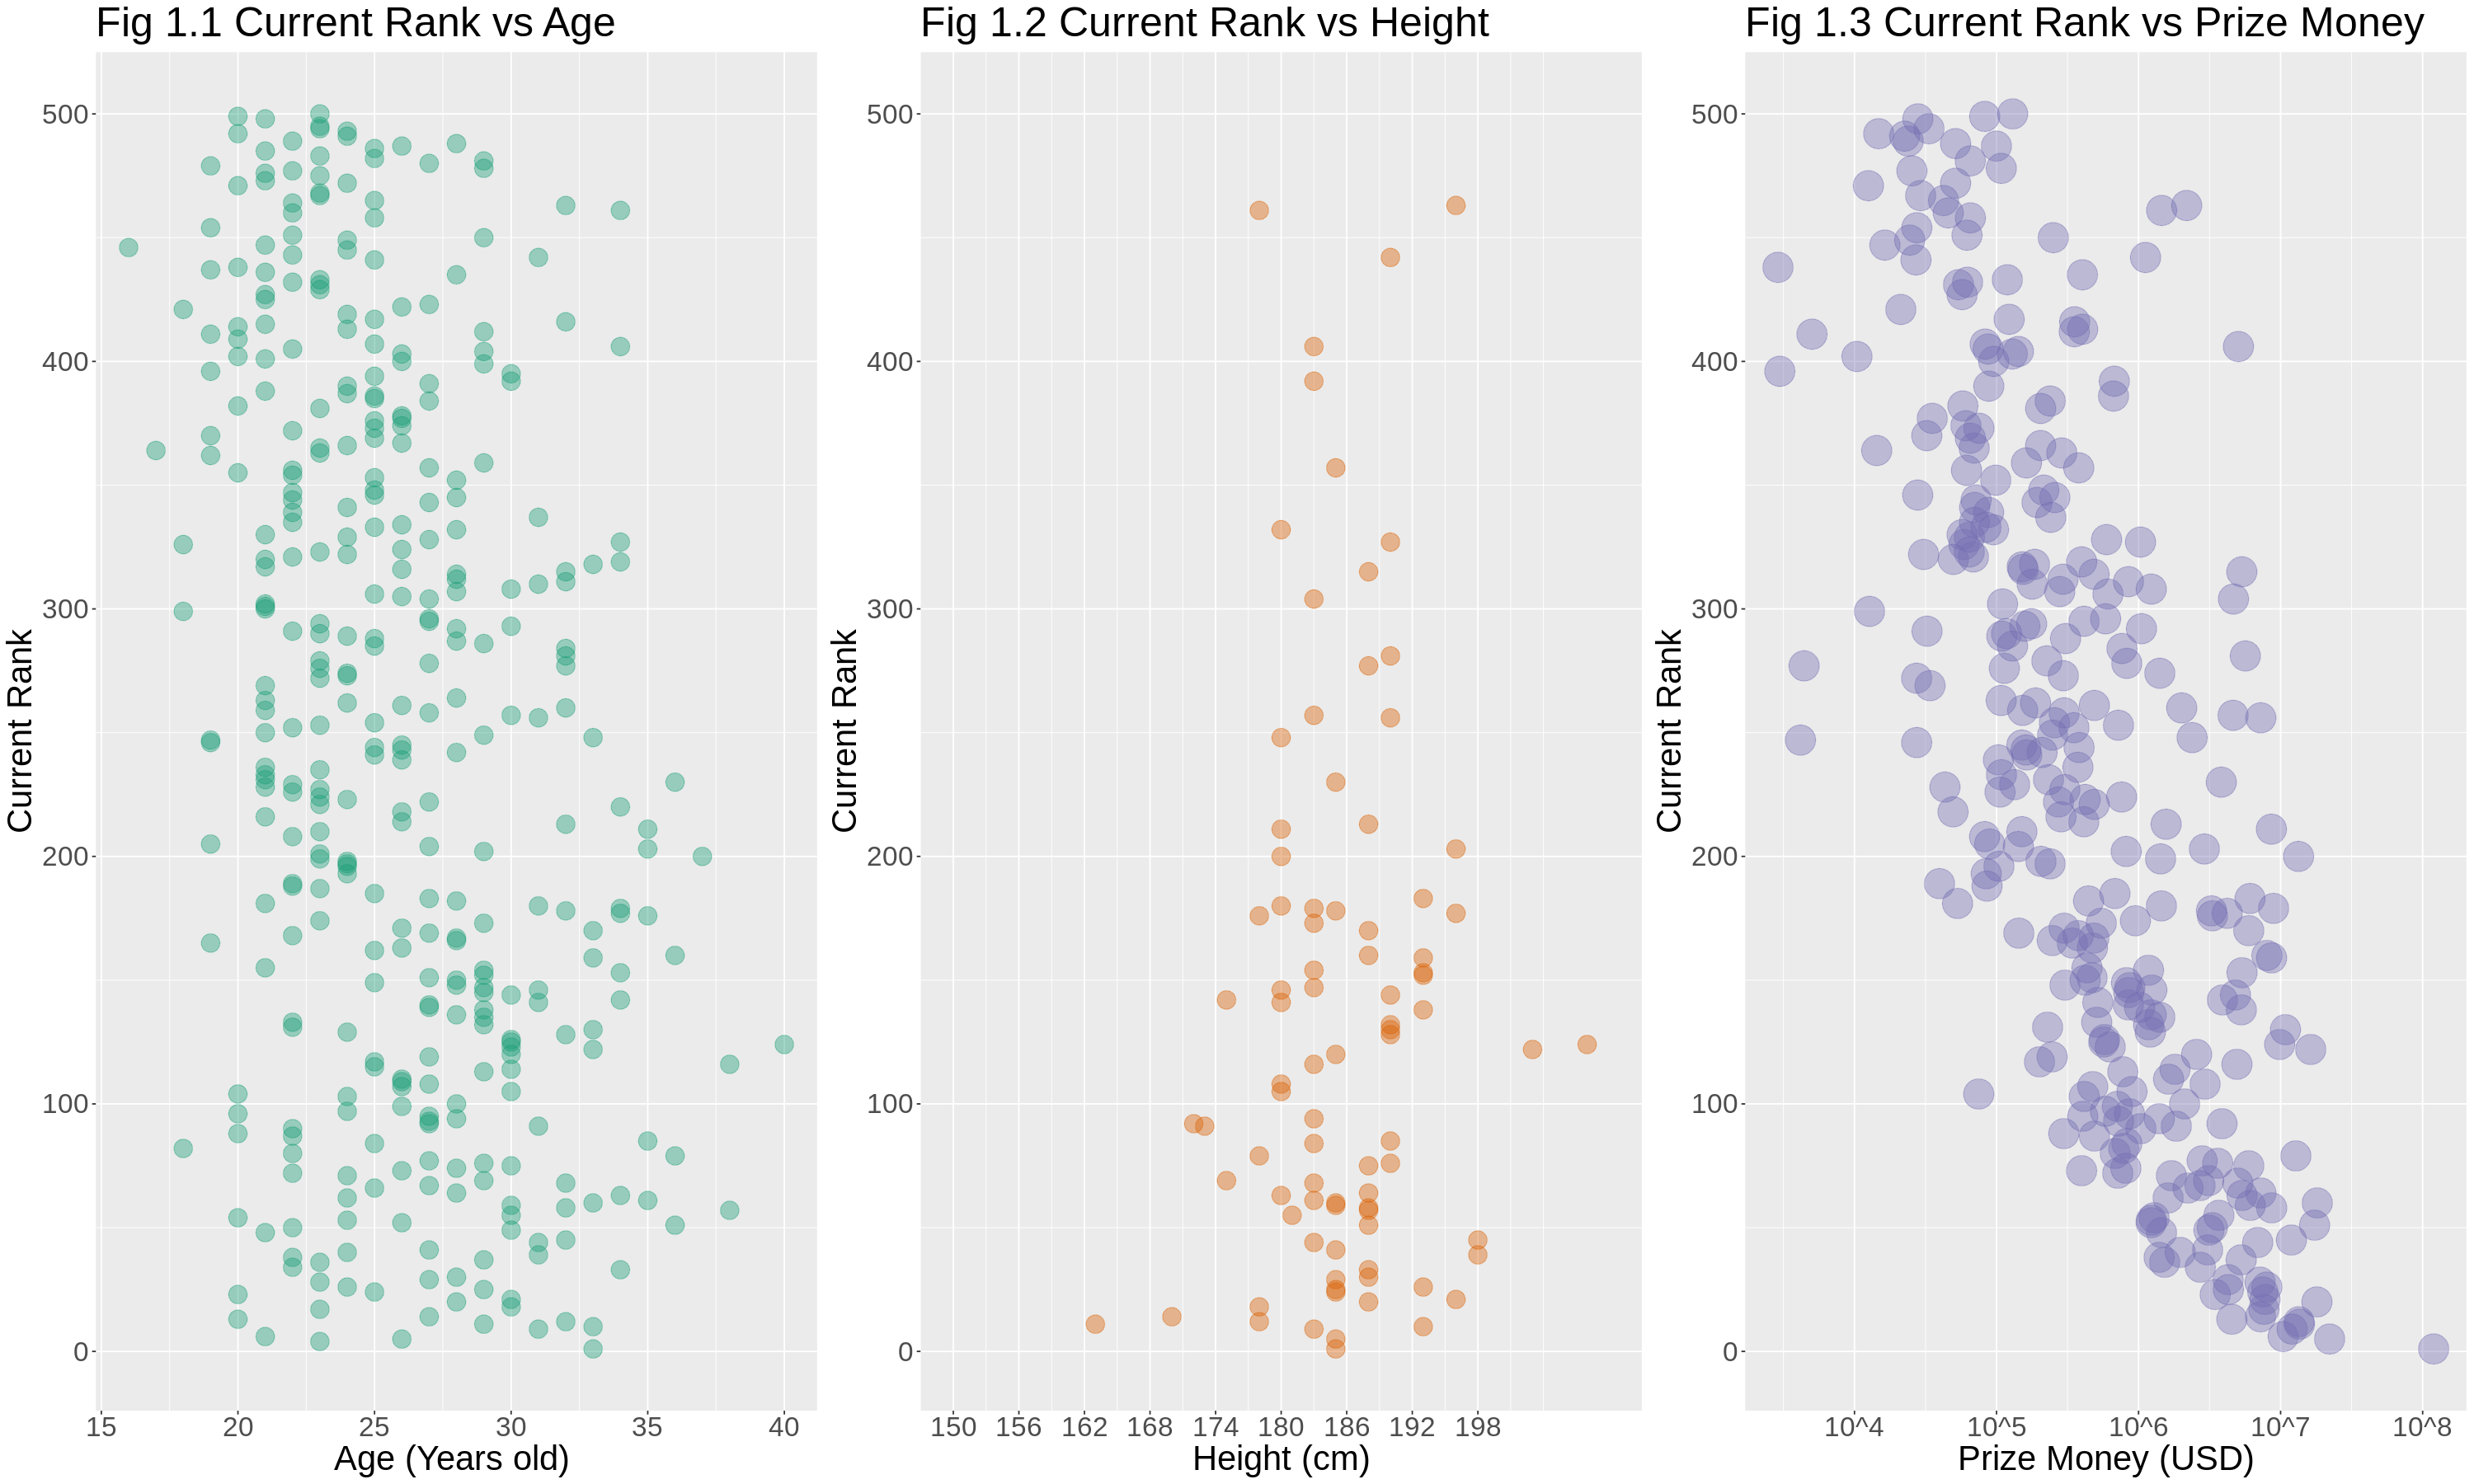

In [61]:
### Visualization Current rank with interesting variable

options(repr.plot.height = 15, repr.plot.width = 25)
age_vs_rank <- ggplot(tennis_train, aes(x = Age, y = Current.Rank)) +
  geom_point(alpha = opacity,  color = color_palette[1], size = 6) +
  labs(x = "Age (Years old) ", y = "Current Rank") +
  ggtitle("Fig 1.1 Current Rank vs Age") +
  theme(text = element_text(size = 25)) 
#age_vs_rank

height_vs_rank <- ggplot(tennis_train, aes(x = Height, y = Current.Rank)) +
  geom_point(alpha = opacity, color = color_palette[2], size = 6) +
  labs(x = "Height (cm)", y = "Current Rank") +
  ggtitle("Fig 1.2 Current Rank vs Height") +
  theme(text = element_text(size = 25)) +
  scale_x_continuous(limits = c(150, 210), breaks = seq(150, 200, by = 6))

#height_vs_rank
prize_vs_rank <- ggplot(tennis_train, aes(x = Prize.Money, y = Current.Rank)) +
  geom_point(alpha = opacity,  
             color = color_palette[3], 
             size = 10,) +
  labs(x = "Prize Money (USD)", y = "Current Rank") +
  ggtitle("Fig 1.3 Current Rank vs Prize Money") +
  scale_x_log10(labels = function(x) sprintf("10^%d", log10(x)), breaks = c(1e3, 1e4, 1e5, 1e6, 1e7, 1e8)) +
  theme(text = element_text(size = 25))

#prize_vs_rank
grid.arrange(age_vs_rank, height_vs_rank, prize_vs_rank, ncol = 3) 

paste("Figure 1")

Figure 1 shows the relationships between current rank and numeric variables respecitively:
<br>
A weak and negative relationship between current rank and age is shown on the graph; 
<br>
There is no obvious relationship between a player’s height and his current rank;
<br>
A strong and negative relationship between current rank and height and prize money is shown by the graph.

Next, we want to see how categorical variables can help predicting the current rank.

Warning message:
“Removed 221 rows containing missing values (geom_point).”
Warning message:
“Removed 16 rows containing missing values (geom_point).”


[1] "Figure 2"

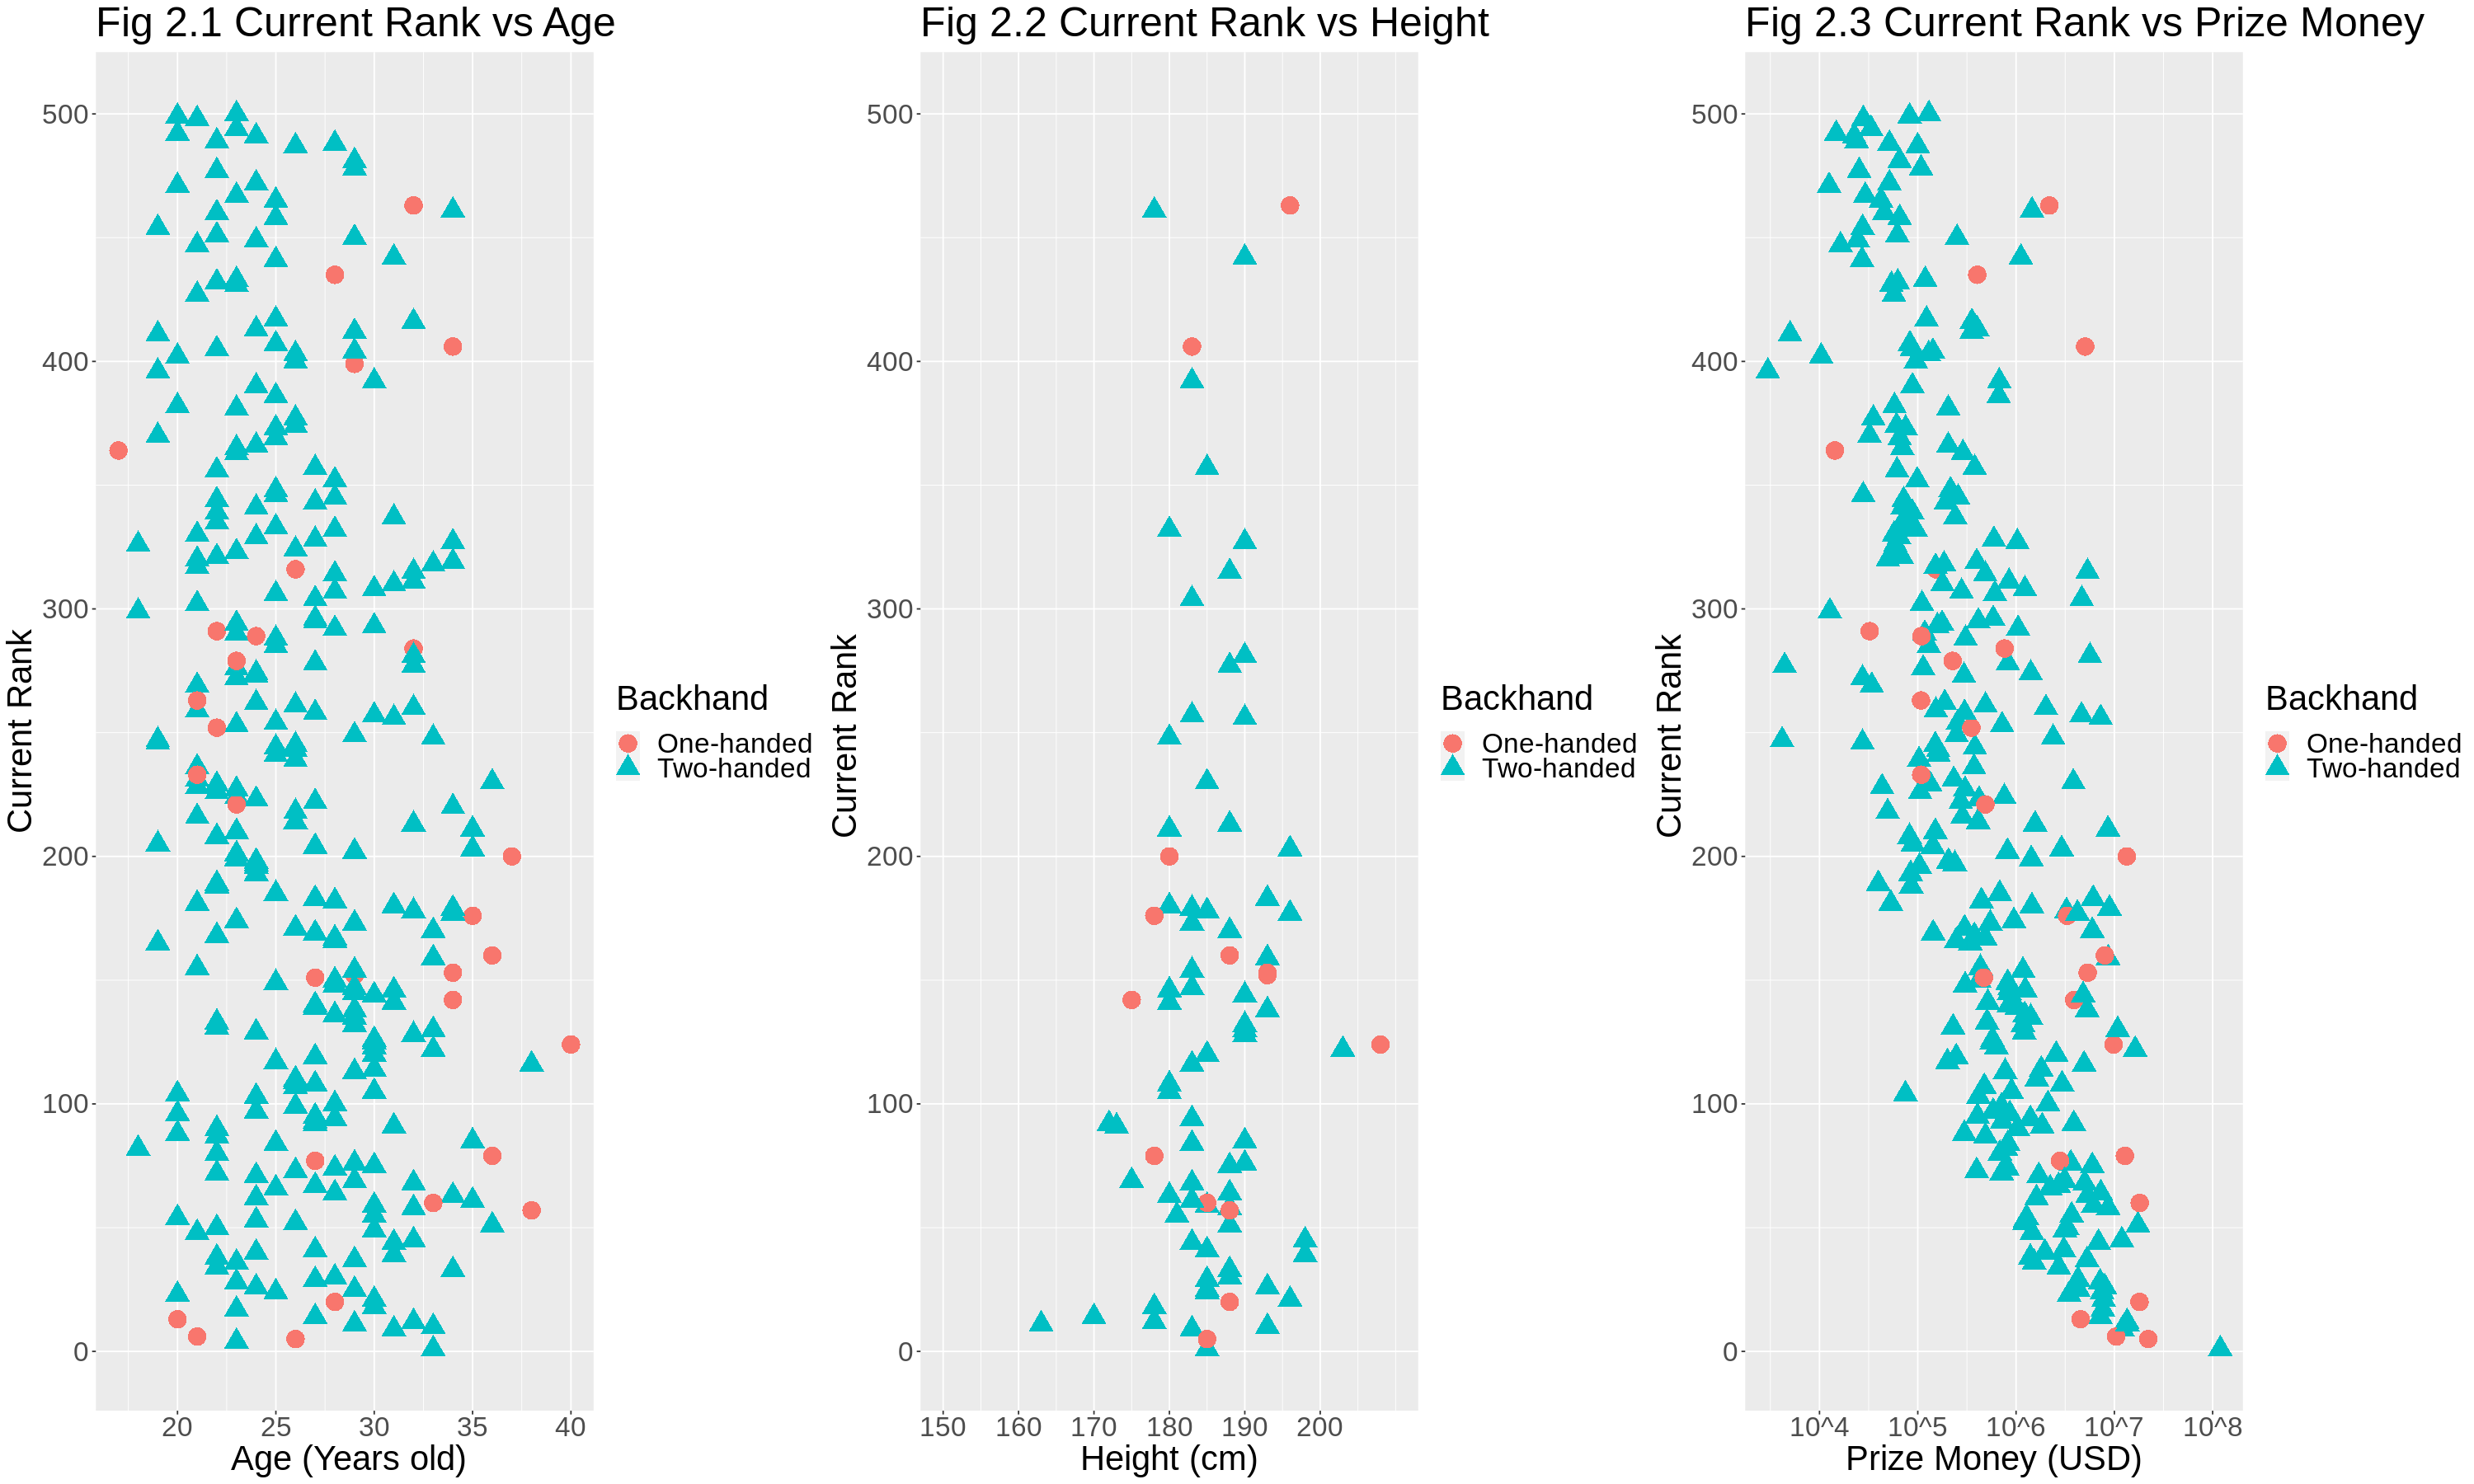

In [62]:
### color and label shape by backhandedness
options(repr.plot.height = 15, repr.plot.width = 25)
age_vs_rank_backhand <- tennis_train|>
                        filter(Backhand != "NA") |>
                        ggplot( aes(x = Age,
                                                 y = Current.Rank, 
                                                 color = Backhand,
                                                shape = Backhand)) +
  geom_point(alpha = 1, size = 6) +
  labs(x = " Age (Years old)", y = "Current Rank") +
  ggtitle("Fig 2.1 Current Rank vs Age") +
  theme(text = element_text(size = 25)) 
#age_vs_rank_backhand

height_vs_rank_backhand <-tennis_train|>
                        filter(Backhand != "NA") |>
                                ggplot( aes(x = Height, 
                                           y = Current.Rank,
                                           color = Backhand,
                                           shape = Backhand)) +
  geom_point(alpha = 1, size = 6) +
  labs(x = "Height (cm)", y = "Current Rank ") +
  ggtitle("Fig 2.2 Current Rank vs Height") +
  theme(text = element_text(size = 25)) +
  scale_x_continuous(limits = c(150, 210), breaks = seq(150, 200, by = 10))

#height_vs_rank_backhand



prize_vs_rank_backhand <- tennis_train|>
                        filter(Backhand != "NA") |>
                        ggplot(aes(x = Prize.Money,
                                          y = Current.Rank,
                                          color = Backhand,
                                          shape = Backhand)) +
  geom_point(alpha = 1,   
             size = 6,) +
  labs(x = "Prize Money (USD)", y = "Current Rank ") +
  ggtitle("Fig 2.3 Current Rank vs Prize Money") +
  scale_x_log10(labels = function(x) sprintf("10^%d", log10(x)), breaks = c(1e3, 1e4, 1e5, 1e6, 1e7, 1e8)) +
  theme(text = element_text(size = 25))

#prize_vs_rank_backhand
grid.arrange(age_vs_rank_backhand, height_vs_rank_backhand, prize_vs_rank_backhand, ncol = 3) 

paste("Figure 2")    

Figure 2 shows the relationships between current rank and numeric variables respecitively, points colored by backhandedness:
<br>
The trends for both two-handedness and one-handedness resemble the trend of overall players, which indicates that backhandedness has no significant influence on the rank of players.

In [63]:
## Create a new sub dataset focusing on the top 10 most popular country
top_10_country <- tennis_train |>
    select(Age, Current.Rank, Country) |>
    group_by(Country) |>
    summarise(count = n()) |>
    arrange(desc(count)) |>
    slice(1:10)
top_10_country
paste("Table 2.1 The Top 10 Most Popular Country")

# Create a vector of allowed countries, including "Others"
allowed_countries <- c("United", "France", "Italy", "Germany", "Spain", "Argentina", "Australia", "Japan", "Russian", "Brazil")

# Mutate the Country column to "Others" if it's not in the allowed_countries vector
country_data <- tennis_train |>
  mutate(Country = factor(if_else(Country %in% allowed_countries, Country, as.factor("Others")))) |>
  filter(!is.na(Country))
# other countries that are not in the top 10 will be labeled as 'NA' and filtered,
# since they don't have significant impact on the ranking of the dataset.

country_data 
paste("Table 2.2 Data Excluding Countries Besides Top 10")

Country,count
<fct>,<int>
United,37
France,34
Italy,31
Germany,26
Spain,25
Argentina,22
Australia,21
Japan,16
Russian,11


[1] "Table 2.1 The Top 10 Most Popular Country"

Warning message in `[<-.factor`(`*tmp*`, i, value = structure(1L, .Label = "Others", class = "factor")):
“invalid factor level, NA generated”


Prize.Money,Age,Country,Plays,Backhand,Height,Current.Rank
<dbl>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>
NA,23,Russian,Right-handed,Two-handed,NA,4
2722314,22,United,Right-handed,Two-handed,NA,34
11912152,32,United,Right-handed,Two-handed,198,45
13470614,32,Italy,Right-handed,Two-handed,178,12
827193,25,France,Right-handed,Two-handed,183,84
⋮,⋮,⋮,⋮,⋮,⋮,⋮
NA,24,United,NA,NA,NA,493
NA,21,Italy,NA,NA,NA,485
NA,25,France,Right-handed,NA,NA,486


[1] "Table 2.2 Data Excluding Countries Besides Top 10"

Warning message:
“Removed 3 rows containing missing values (geom_point).”
Warning message:
“Removed 180 rows containing missing values (geom_point).”
Warning message:
“Removed 55 rows containing missing values (geom_point).”


[1] "Figure 3"

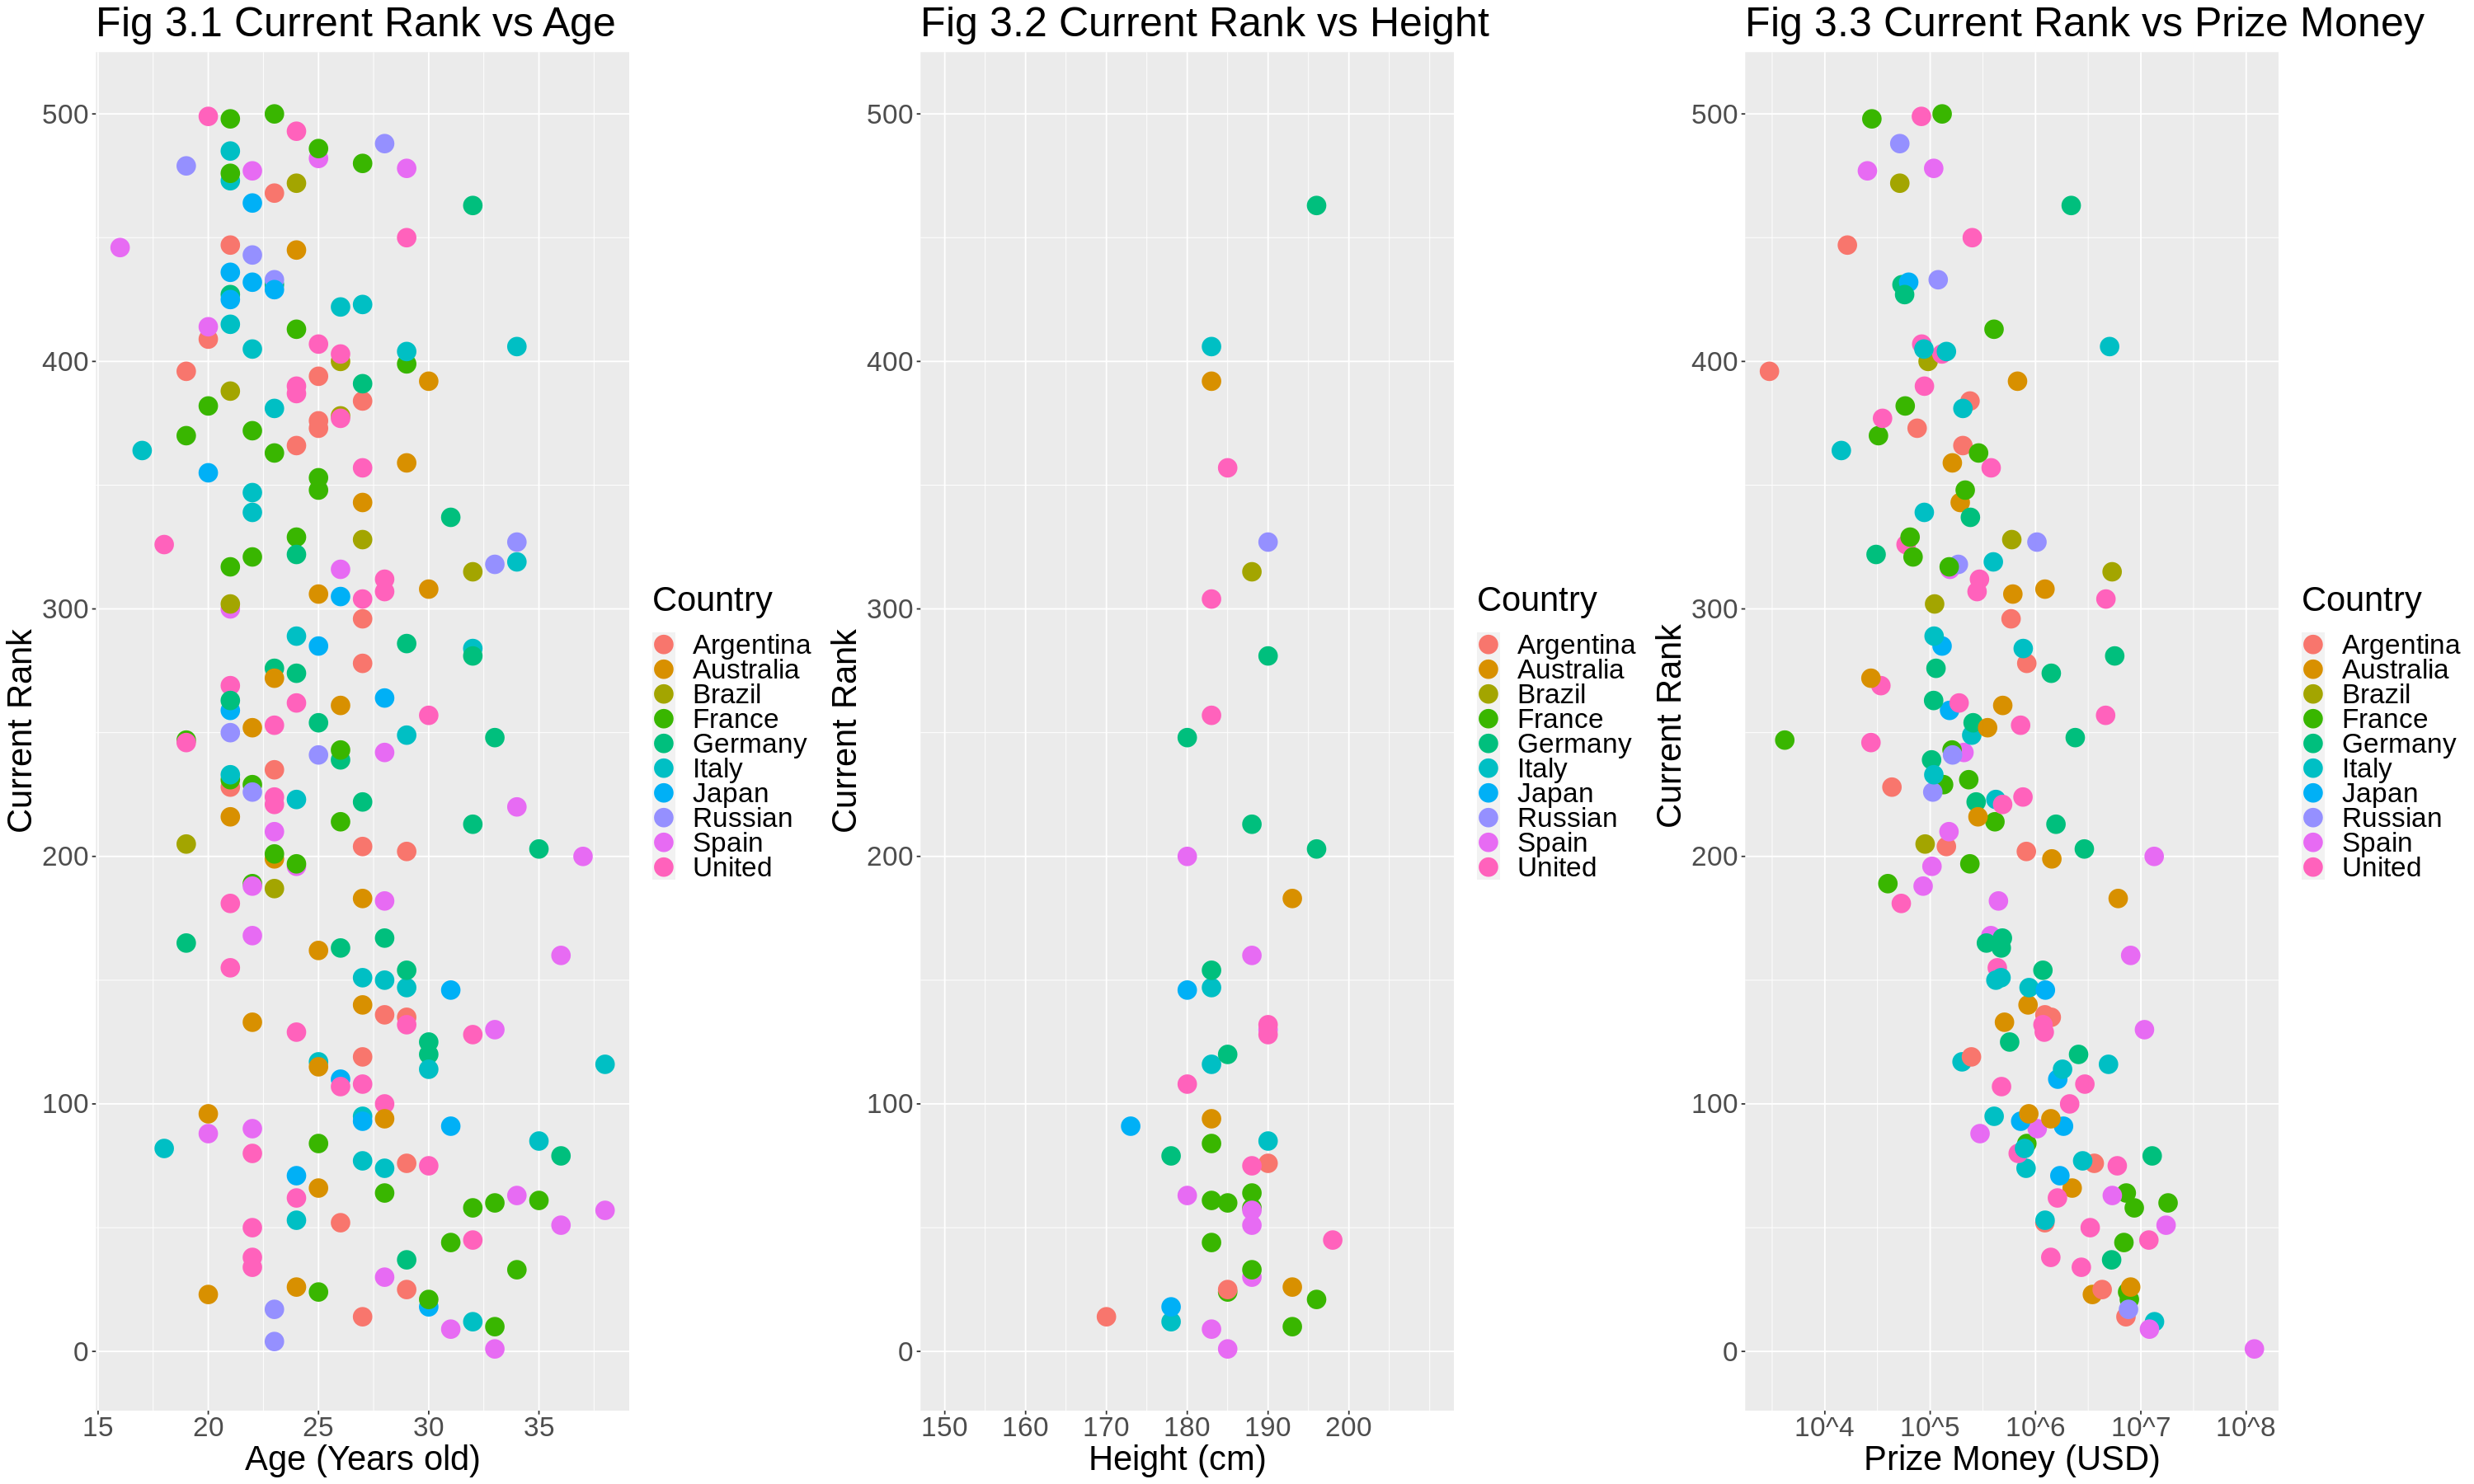

In [64]:
### color and label shape by Country
options(repr.plot.height = 15, repr.plot.width = 25)
age_vs_rank_country <- country_data|>
                        filter(Country != "NA")|>
                        ggplot( aes(x = Age,
                                y = Current.Rank, 
                                color = Country)) +
  geom_point(alpha = 1, size = 6) +
  labs(x = "Age (Years old)", y = "Current Rank") +
  ggtitle("Fig 3.1 Current Rank vs Age") +
  theme(text = element_text(size = 25)) 


height_vs_rank_country <- country_data|>
                            filter(Country != "NA")|>
                            ggplot(aes(x = Height, 
                                           y = Current.Rank,
                                           color = Country)) +
  geom_point(alpha = 1, size = 6) +
  labs(x = "Height (cm)  ", y = "Current Rank") +
  ggtitle("Fig 3.2 Current Rank vs Height") +
  theme(text = element_text(size = 25)) +
  scale_x_continuous(limits = c(150, 210), breaks = seq(150, 200, by = 10))

prize_vs_rank_country <- country_data|>
                            filter(Country != "NA")|>
                            ggplot(aes(x = Prize.Money,
                                          y = Current.Rank,
                                          color = Country)) +
  geom_point(alpha = 1,   
             size = 6,) +
  labs(x = "Prize Money (USD)", y = " Current Rank") +
  ggtitle("Fig 3.3 Current Rank vs Prize Money") +
  scale_x_log10(labels = function(x) sprintf("10^%d", log10(x)), breaks = c(1e3, 1e4, 1e5, 1e6, 1e7, 1e8)) +
  theme(text = element_text(size = 25))
                
grid.arrange(age_vs_rank_country,height_vs_rank_country,prize_vs_rank_country, ncol = 3) 
paste("Figure 3")  

Figure 3 shows the relationships between current rank and numeric variables respecitively, points colored by country where players come from:
<br>
The data of players from different countries are randomly distributed among graphs of all three variables we are inspecting, still indicating players origin has no significant impact on current rankings. There is no particular pattern that show the relationship between country and current rank.

Warning message:
“Removed 252 rows containing missing values (geom_point).”
Warning message:
“Removed 42 rows containing missing values (geom_point).”


[1] "Figure 4"

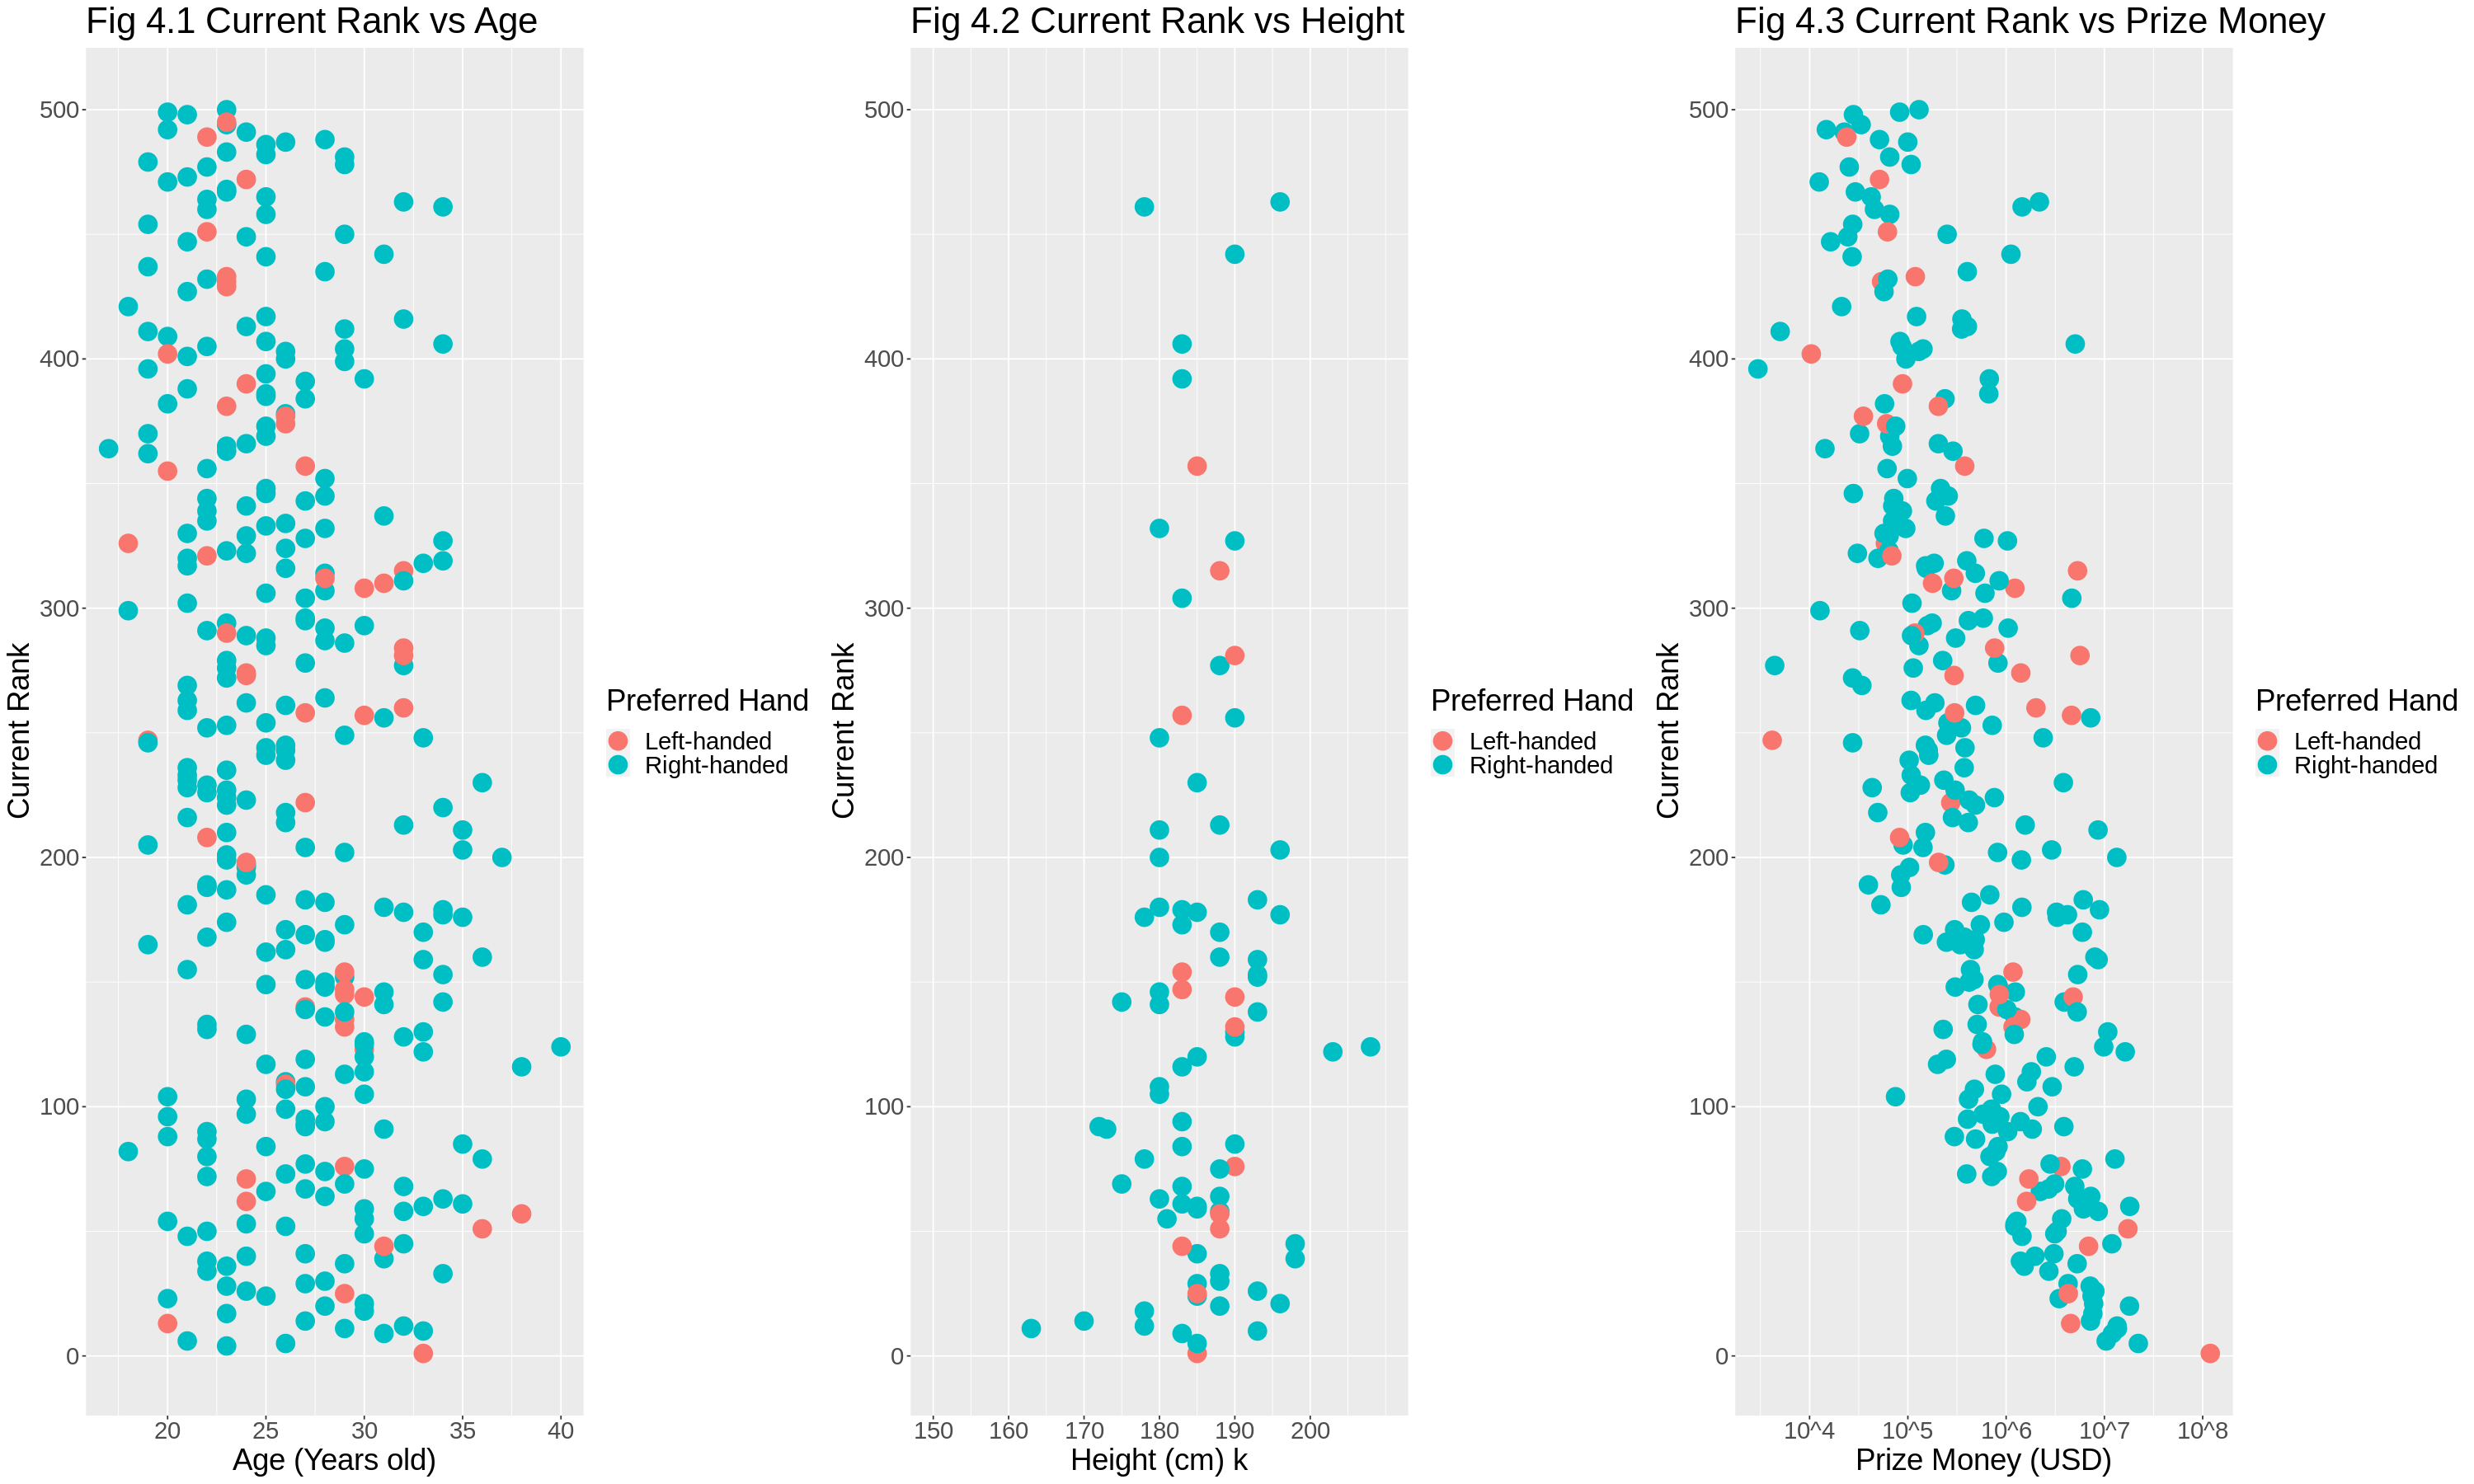

In [65]:
#coloring by preferred hand
options(repr.plot.height = 15, repr.plot.width = 25)
age_vs_rank_hand <- tennis_train|>
                        filter(Plays != "NA") |>
                                    ggplot( aes(x = Age,
                                            y = Current.Rank, 
                                            color = Plays)) +
  geom_point(alpha = 1, size = 6) +
  labs(x = "Age (Years old)", y = "Current Rank", color = "Preferred Hand") +
  ggtitle("Fig 4.1 Current Rank vs Age") +
  theme(text = element_text(size = 22)) 
#age_vs_rank_hand

height_vs_rank_hand <- tennis_train|>
                        filter(Plays != "NA") |>
                        ggplot( aes(x = Height, 
                                           y = Current.Rank,
                                           color = Plays)) +
  geom_point(alpha = 1, size = 6) +
  labs(x = "Height (cm) k", y = "Current Rank", color = "Preferred Hand") +
  ggtitle("Fig 4.2 Current Rank vs Height") +
  theme(text = element_text(size = 22)) +
  scale_x_continuous(limits = c(150, 210), breaks = seq(150, 200, by = 10))

#height_vs_rank_hand



prize_vs_rank_hand <- tennis_train|>
                        filter(Plays != "NA") |>
                        ggplot(aes(x = Prize.Money,
                                          y = Current.Rank,
                                          color = Plays)) +
  geom_point(alpha = 1,   
             size = 6,) +
  labs(x = "Prize Money (USD)", y = "Current Rank", color = "Preferred Hand") +
  ggtitle("Fig 4.3 Current Rank vs Prize Money") +
  scale_x_log10(labels = function(x) sprintf("10^%d", log10(x)), breaks = c(1e3, 1e4, 1e5, 1e6, 1e7, 1e8)) +
  theme(text = element_text(size = 22))
#prize_vs_rank_hand

grid.arrange(age_vs_rank_hand,height_vs_rank_hand,prize_vs_rank_hand, ncol = 3) 
paste("Figure 4")  

Figure 4 shows the relationships between current rank and numeric variables respecitively, points colored by preferred hand:
<br>
The trends for both left-handedness and right-handedness resemble the trend of overall players, which indicates that preferred hand has no significant influence on the rank of players.

Since there is no correlation between current rank, and country, backhandness or preferred hand, we would ignore these variables while we choose age, height, and prize money to be our variable of interest. Recalling that height has a very high missing data percentage, so we will not using this variable to build the model, which leave us with age and prize money.

### Methods
For this analysis, we will use the player's age and prize money earned for data training. These choices of predictor variables are made based on our preliminary data analysis, as the other interested variables did not display any relationship (country, handedness, etc) or have a high missing data ratio (height). Furthermore, the main reason we chose our two variables(age and prize money earned) is that there is possibly a relationship between them and the current rank.

After cleaning up the data, we will perform five-fold cross-validation and examine the RMPSE value. Since we use numerical variables (age and prize money) to predict another numerical variable (current rank), we will use the K-nearest neighbours regression.

Since we are visualizing the distribution and relation between many variables, we should use a scatterplot to correctly represent the data to understand the relation between the different variables. We prioritize a 2D plot over a 3D one because it is more commonly viewed. We will also use a line graph to highlight the predicted values so that the viewer can easily visualize the RMSE values.

From the analysis, we chose age and prize money earned as our predictor, so we wanted to drop all the irrelevant variables.

In [66]:
tennis_train <- select(tennis_train, Current.Rank, Age, Prize.Money) |> drop_na()
paste("Final training data")
tennis_train
tennis_test <- select(tennis_test, Current.Rank, Age, Prize.Money) |> drop_na()
paste("Final testing data")
tennis_test

[1] "Final training data"

Current.Rank,Age,Prize.Money
<dbl>,<dbl>,<dbl>
104,20,74927
54,20,1285541
34,22,2722314
45,32,11912152
105,30,898701
⋮,⋮,⋮
405,22,87242
500,23,129874
416,32,354975


[1] "Final testing data"

Current.Rank,Age,Prize.Money
<dbl>,<dbl>,<dbl>
31,22,1517157
232,21,59123
22,19,1893476
134,28,439427
121,31,25889586
⋮,⋮,⋮
298,26,105238
360,18,31170
207,27,310368


We will use K-nearest neighbors regression to predict tennis players' ranks. Regression will be used because we will be predicting a numerical variable (player ranking). The model also worked with our data analysis, since we are trying to use 2 predictors (age and prize money), and furthermore, the relationship between the predictors and the Current Rank is considered to be non-linear.

In order to achieve the best results, we will create and test several models with different combinations of our variables of interest (age and prize money earned), and select the combination which yields the highest accuracy. We also perform cross validation on the training data set to choose the best K value.

First we will use only age.

In [67]:
# Now we will perform cross validation to choose the optimal K
set.seed(420)
#split the training data set for cross-validation
vfold <- vfold_cv(tennis_train, v = 5, strata = Current.Rank)

knn_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>  
            set_engine("kknn") |>  
            set_mode("regression")

tennis_age_recipe <- recipe(Current.Rank ~ Age, data = tennis_train) |>  
            step_scale(all_predictors()) |>  
            step_center(all_predictors())

age_wkflw <- workflow() |>
  add_recipe(tennis_age_recipe) |>
  add_model(knn_spec)

age_wkflw

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


The following code tunes the model and return the K value for the lowest RMSPE 

In [68]:
# run cross-validation for a grid of neighbors ranging from 1 to 80, jump 3 step at a time to reduce the running time.
gridv <- tibble(neighbors = seq(from = 1, to = 80, by = 3))

age_results <- age_wkflw |>
  tune_grid(resamples = vfold, grid = gridv) |>
  collect_metrics() |>
  filter(.metric == "rmse") |>
  filter(mean == min(mean))

paste("Optimal number of neighbors (K)")
age_results
paste("Table 3")

[1] "Optimal number of neighbors (K)"

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
79,rmse,standard,134.717,5,3.116198,Preprocessor1_Model27


[1] "Table 3"

According to Table 3, the optimal K value for using only age as a predicting variable is 79. We also want to record the RMSPE for evaluating how well our model can predict an unseen data. 

In [69]:
#take the optimal k value
kmin <- age_results |> pull(neighbors)

#re-train the model with the k value
age_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = kmin) |>  
            set_engine("kknn") |>  
            set_mode("regression")

#create the workflow
age_fit <- workflow() |>  
        add_recipe(tennis_age_recipe) |>  
        add_model(age_spec) |>  
        fit(data = tennis_train)

#use the new model to predict the testing data, and record the RMSPE value
age_summary <- age_fit |>
  predict(tennis_test) |>
  bind_cols(tennis_test) |>
  metrics(truth = Current.Rank, estimate = .pred) |>
  filter(.metric == 'rmse')
age_summary
paste("Table 4")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,143.2088


[1] "Table 4"

According to Table 4, the RMSPE value for using only age as a predicting variable is around 143.

Next, we are going to go through the same process but use prize money earned variable instead.

In [70]:
# Now we will perform cross validation to choose the optimal K
set.seed(420)
#split the training data set for cross-validation
vfold <- vfold_cv(tennis_train, v = 5, strata = Current.Rank)

knn_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>  
            set_engine("kknn") |>  
            set_mode("regression")

tennis_prize_recipe <- recipe(Current.Rank ~ Prize.Money, data = tennis_train) |>  
            step_scale(all_predictors()) |>  
            step_center(all_predictors())

prize_wkflw <- workflow() |>
  add_recipe(tennis_prize_recipe) |>
  add_model(knn_spec)

prize_wkflw

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


The following code tunes the model and return the K value for the lowest RMSPE

In [71]:
# run cross-validation for a grid of neighbors ranging from 1 to 80, jump 3 step at a time to reduce the running time.
gridv <- tibble(neighbors = seq(from = 1, to = 80, by = 3))

prize_results <- prize_wkflw |>
  tune_grid(resamples = vfold, grid = gridv) |>
  collect_metrics() |>
  filter(.metric == "rmse") |>
  filter(mean == min(mean))

paste("Optimal number of neighbors (K)")
prize_results
paste("Table 5")

[1] "Optimal number of neighbors (K)"

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
43,rmse,standard,96.69745,5,1.762173,Preprocessor1_Model15


[1] "Table 5"

Accoridng to Table 5, the optimal K value for using only prize money as a predicting variable is 43. Now we are going to use that K value to evaluate how good the model on predicting an unseen data.

In [72]:
#take the optimal k value
kmin <- prize_results |> pull(neighbors)

#re-train the model with the k value
prize_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = kmin) |>  
            set_engine("kknn") |>  
            set_mode("regression")

#create the workflow
prize_fit <- workflow() |>  
        add_recipe(tennis_prize_recipe) |>  
        add_model(prize_spec) |>  
        fit(data = tennis_train)

#use the new model to predict the testing data, and record the RMSPE value
age_summary <- prize_fit |>
  predict(tennis_test) |>
  bind_cols(tennis_test) |>
  metrics(truth = Current.Rank, estimate = .pred) |>
  filter(.metric == 'rmse')
age_summary
paste("Table 6")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,113.3396


[1] "Table 6"

Accoridng to Table 6, the RMSPE value for using only prize money as a predicting variable is around 113.

Next, we want evaluate a model useing both Prize money and Age to predict the current rank of a player. The same as before, we firstly perform cross-validation to choose the optimal K.

In [73]:
# Now we will perform cross validation to choose the optimal K
set.seed(420)
#split the training data set for cross-validation
vfold <- vfold_cv(tennis_train, v = 5, strata = Current.Rank)

knn_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>  
            set_engine("kknn") |>  
            set_mode("regression")

tennis_pa_recipe <- recipe(Current.Rank ~ ., data = tennis_train) |>  
            step_scale(all_predictors()) |>  
            step_center(all_predictors())

pa_wkflw <- workflow() |>
  add_recipe(tennis_pa_recipe) |>
  add_model(knn_spec)

pa_wkflw

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


The following code tunes the model and return the K value for the lowest RMSPE

In [74]:
# run cross-validation for a grid of neighbors ranging from 1 to 80, jump 3 step at a time to reduce the running time.
gridv <- tibble(neighbors = seq(from = 1, to = 80, by = 3))

pa_results <- pa_wkflw |>
  tune_grid(resamples = vfold, grid = gridv) |>
  collect_metrics() |>
  filter(.metric == "rmse") |>
  filter(mean == min(mean))

pa_results
paste("Table 7. Optimal number of neighbors (K)")

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
7,rmse,standard,102.3153,5,1.235974,Preprocessor1_Model03


[1] "Table 7. Optimal number of neighbors (K)"

Accoridng to Table 7, the optimal K value for using both Prize Money and Age as predicting variables is 7. 
<br>
Now we are going to use that K value to evaluate how good the model on predicting an unseen data

In [75]:
#take the optimal k value
kmin <- pa_results |> pull(neighbors)

#re-train the model with the k value
pa_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = kmin) |>  
            set_engine("kknn") |>  
            set_mode("regression")

#create the workflow
pa_fit <- workflow() |>  
        add_recipe(tennis_pa_recipe) |>  
        add_model(pa_spec) |>  
        fit(data = tennis_train)

#use the new model to predict the testing data, and record the RMSPE value
pa_summary <- pa_fit |>
  predict(tennis_test) |>
  bind_cols(tennis_test) |>
  metrics(truth = Current.Rank, estimate = .pred) |>
  filter(.metric == 'rmse')
pa_summary
paste("Table 8")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,108.7971


[1] "Table 8"

According to Table 8, the RMSPE value for using only age as a predicting variable is around 109.

Comparing the 3 models that is create from combination between Prize Money and Age, we conclude that the model that use both Prize Money and Age to predict the player current rank have the lowest RMSPE, therefore, being the best model. To further evaluate on this, we will plot our prediction using all 3 models

In [80]:
#plot for age:
tennis_age_preds <- age_fit |>  
            predict(tennis_test) |>  
            bind_cols(tennis_test)

age_plot <- ggplot(tennis_train, aes(x = Age, y = Current.Rank)) +
  geom_point(alpha = 1) +
  geom_line(data = tennis_age_preds, 
            mapping = aes(x = Age, y = .pred), 
            color = "blue") +
  xlab("Age") +
  ylab("Current Rank") +
  scale_y_continuous() +
  ggtitle(paste0("Figure 5.1 Prediction on Age, K = 79")) + 
  theme(text = element_text(size = 20))


In [81]:
#plot for prize money

tennis_prize_preds <- prize_fit |>  
            predict(tennis_test) |>  
            bind_cols(tennis_test)

prize_plot <- ggplot(tennis_train, aes(x = Prize.Money, y = Current.Rank)) +
  geom_point(alpha = 1) +
  geom_line(data = tennis_prize_preds, 
            mapping = aes(x = Prize.Money, y = .pred), 
            color = "blue") +
  xlab("Prize Earned ($)") +
  ylab("Current Rank") +
  scale_y_continuous() +
  ggtitle(paste0("Figure 5.2 Prediction on Prize.Money, K = 79")) + 
  theme(text = element_text(size = 20)) +
  scale_x_log10(labels = function(x) sprintf("10^%d", log10(x)), breaks = c(1e3, 1e4, 1e5, 1e6, 1e7, 1e8)) 


[1] "Figure 5"

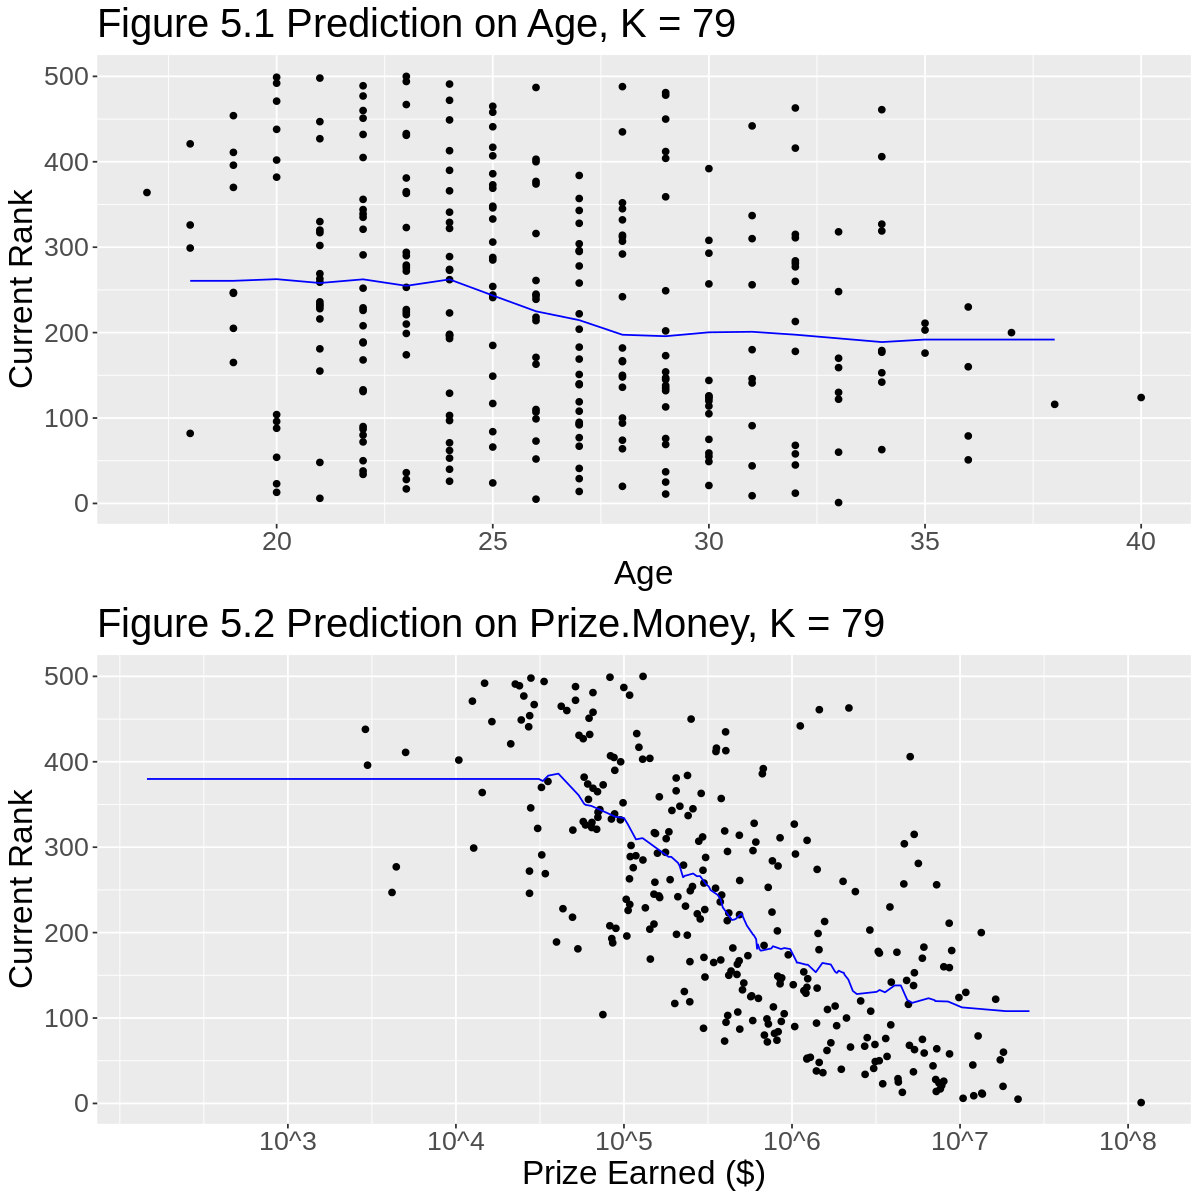

In [82]:
options(repr.plot.width = 10, repr.plot.height = 10)
paste("Figure 5")
library(cowplot)
plot_grid(age_plot, prize_plot, nrow = 2, align = "h", rel_widths = c(1, 1))

Although we planned to visualize the result of the best model (that use Prize.Money and Age as predictors), we end up couldn't make the plot easy to view (mainly because we can't find away to actually use the library). As such, we will plot matrix between the variable to examine the relationship between them, and comparing to the predicted value.

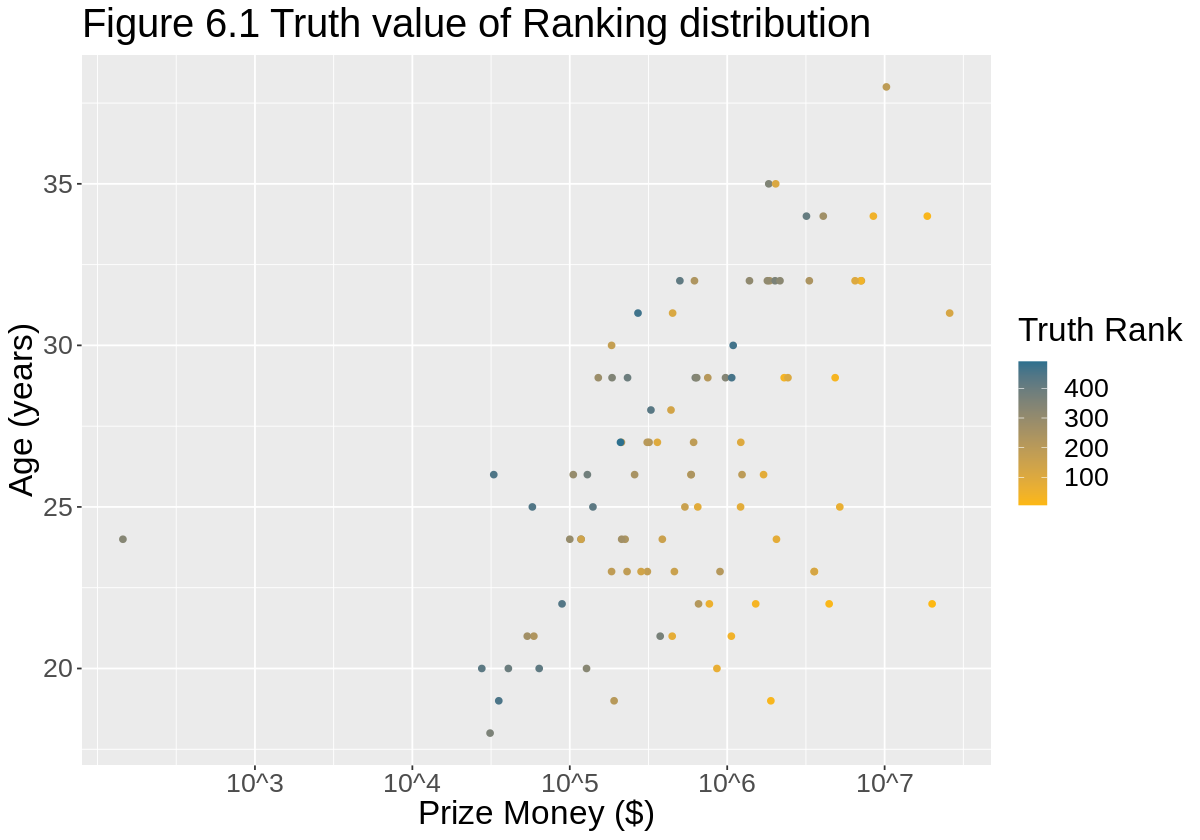

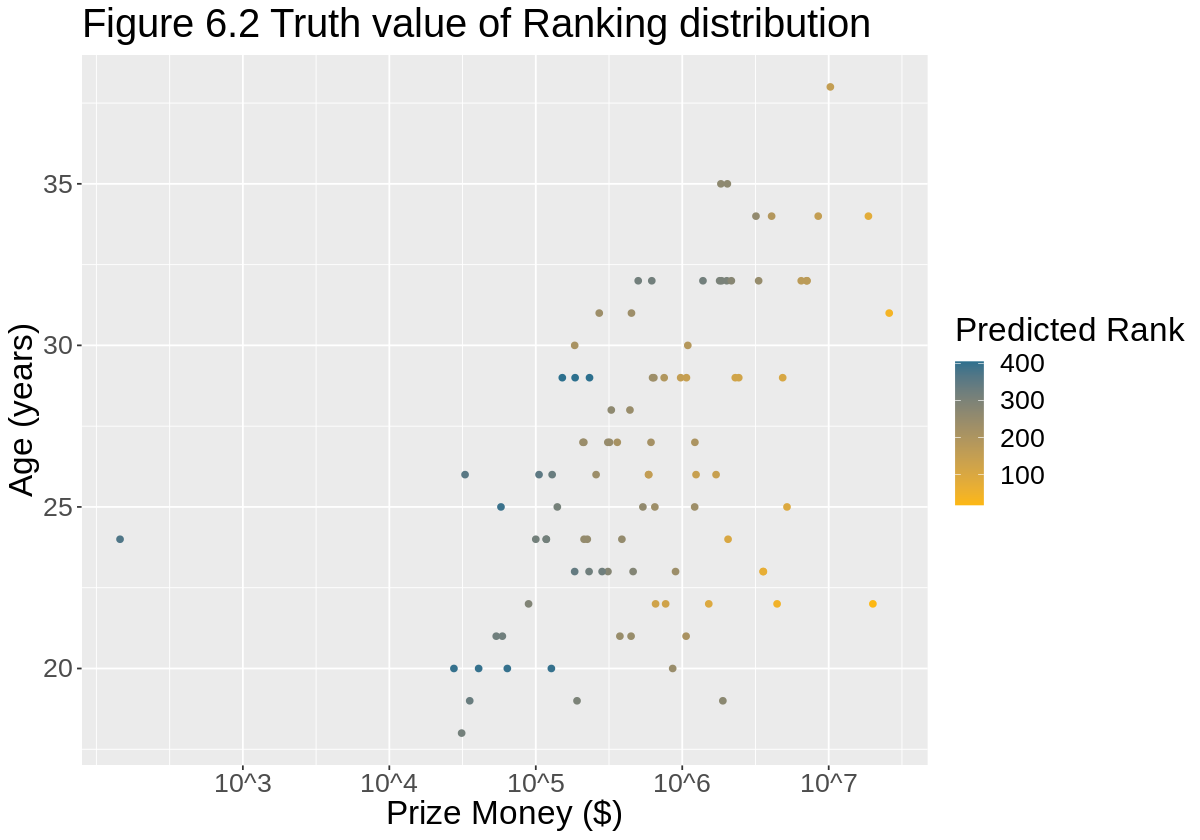

In [84]:
all_preds <- pa_fit |>  
            predict(tennis_test) |>  
            bind_cols(tennis_test)
options(repr.plot.width = 10, repr.plot.height = 7)
truth_plot <- ggplot(all_preds, aes(x = Prize.Money, y = Age, color = Current.Rank)) +
  geom_point(alpha = 1) +
  xlab("Prize Earned ($)") +
  ylab("Age") +
  scale_y_continuous() +
  ggtitle(paste0("Figure 6.1 Truth value of Ranking distribution")) + 
  theme(text = element_text(size = 20)) +
  scale_x_log10(labels = function(x) sprintf("10^%d", log10(x)), breaks = c(1e3, 1e4, 1e5, 1e6, 1e7, 1e8)) +
  scale_color_gradient(low = "#FDB813", high = "#2D708E") +
  labs(x = "Prize Money ($)",
       y = "Age (years)",
       color = "Truth Rank")
                
truth_plot          
                
predict_plot <- ggplot(all_preds, aes(x = Prize.Money, y = Age, color = .pred)) +
  geom_point(alpha = 1) +
  scale_y_continuous() +
  ggtitle(paste0("Figure 6.2 Truth value of Ranking distribution")) + 
  theme(text = element_text(size = 20)) +
  scale_x_log10(labels = function(x) sprintf("10^%d", log10(x)), breaks = c(1e3, 1e4, 1e5, 1e6, 1e7, 1e8)) +
  scale_color_gradient(low = "#FDB813", high = "#2D708E") +
  labs(x = "Prize Money ($)",
       y = "Age (years)",
       color = "Predicted Rank")
predict_plot



### Discussion


##### Summarize 
As described in the introduction, our project's main goal was to create a model that would predict the tennis player's rank depending on information from ATP rankings about the tennis player's age, height, and prize money received in the tournament.

Our decision to use only these three predictors was solely based on the relevance of the variables in the dataset, and we believed that nickname, social media information, and country of origin were less relevant than height, age and prize money. While cleaning the data, we discovered that a large portion of the tennis players' heights was missing. To have a higher level of accuracy, we decided not to use this variable for building our prediction model. We reduced the percentage of mistakes that resulted from a small number of data points by removing this variable in our prediction, ensuring higher-quality data for our model.

Throughout our analysis, we investigated the effect of different predicting variables on our model's level of accuracy. When using only prize money as our predicting variable, the Root Mean Square Percentage Error (RMSPE) value of our model was roughly 113, while when using only age as our predictor, the RMSPE value of our model was around 143. Finally, when we set age and prize money as predicting variables, we found that the RMSPE value was 109, and we chose this model to be the best model.

##### Whether this is what you expected to find?
From the Preliminary exploratory data analysis, we found that the relationship between a player's current rank and age is less linear than with his prize money owned. From this observation, we predicted that the best model would use only prize money as the predictor. However, we found that by using age and prize money, we achieve the smallest RMSPE for our model. This might be explained by the fact that although not linear, there is still some pattern in the relationship between age and current rank that can be used to predict one from another.

##### What impact could such findings have?
This result impacted the implications of our model and was slightly different from our initial hypothesis for the model. These results prompted whether other variables could have an even more significant influence on forecasting a player's ranking or whether the dataset should be enlarged to include more recent events to determine the effect of age and prize money.

The fact that a model can predict a player ranking with their age and prize money earned shows some relationship between these variables, and this relationship should be studied more carefully, as there are not enough studies examining this topic. However, Casper and Jonathan (2007) have found that for higher incomes, tennis players tend to commit more to the sport, and this will set a good foundation to study how this can affect a player's ranking. On the other hand, Ulbricht and Alexander (2015) found a disadvantage for lower-age teenagers compared to older players. In our data analysis, this study should also be extended to the players with a mean age (26).

##### What future questions could this lead to?
Our prediction model raises these future questions:

Could we predict the age at which the tennis player should retire? What is the minimum value of RMSPE that our prediction model can achieve if we had a different dataset? If we had a larger dataset with fewer missing values, would the type of backend affect our prediction analysis? Some other question that is more sport related can be:

What other possible predictors beyond our dataset may influence a player's current rank?

We eliminate more than half of the variables in the dataset because they might not be relevant, but is this a correct choice? More specifically, where a player is from can be an excellent predictor of how good a player is. From there, one can study how each country treats tennis specifically and, more generally, sports.

### Citation
Casper, Jonathan. “Sport Commitment, Participation Frequency and Purchase Intention Segmentation Based on Age, Gender, Income and Skill Level with US Tennis Participants.” European Sport Management Quarterly, vol. 7, no. 3, 2007, pp. 269–282., https://doi.org/10.1080/16184740701511110. 

CN, Prajwal. “How to Use Sub() and GSUB() in R.” DigitalOcean, DigitalOcean, 6 Dec. 2022, https://www.digitalocean.com/community/tutorials/sub-and-gsub-function-r. 

“Creating Functions.” Creating Functions – Programming with R, The Carpentries, https://swcarpentry.github.io/r-novice-inflammation/02-func-R/. 

Ulbricht, Alexander, et al. ‘The Relative Age Effect and Physical Fitness Characteristics in German Male Tennis Players’. Journal of Sports Science & Medicine, vol. 14, Sept. 2015, pp. 634–642., https://www.researchgate.net/publication/280919567_The_Relative_Age_Effect_and_Physical_Fitness_Characteristics_in_German_Male_Tennis_Players

Wickham, Hadley. “Simple, Consistent Wrappers for Common String Operations.” Simple, Consistent Wrappers for Common String Operations •, https://stringr.tidyverse.org/. 

Wickham, Hadley, et al. Vectorised If-Else, https://dplyr.tidyverse.org/reference/if_else.html. 

“SPRINTF: Use C-Style String Formatting Commands.” RDocumentation, https://www.rdocumentation.org/packages/base/versions/3.6.2/topics/sprintf. 